In [1]:
import os
import random
import requests
import json
from tqdm import tqdm
from pprint import pprint
from natsort import natsorted

import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold

PATH = os.path.join(os.getcwd(), 'data')
IMAGE_PATH = os.path.join(PATH, 'preprocessed images')
CHARACTER_PATH = os.path.join(IMAGE_PATH, 'chars_segmented')

# Metadata Plat

In [2]:
metadata = pd.read_csv(os.path.join(PATH, 'images', 'plates.csv'), sep=';', index_col=0)
metadata

,plate,bukan_biru,note
index,,,
1,g12201,NaN,NaN
2,gt9571,NaN,NaN
3,g02003,NaN,NaN
4,g12758,NaN,NaN
5,g05016,NaN,NaN
...,...,...,...
806,g04186,NaN,NaN
807,g0110,1.0,NaN
808,g00571,NaN,NaN


In [3]:
# Ambil yang nonbiru sesuai batasan masalah
metadata_non_biru = metadata[metadata['bukan_biru'] != 1][['plate']].copy()
indeks_non_biru = metadata_non_biru.index.to_list()
for i in range(6):
    metadata_non_biru[f'char_{i}'] = metadata_non_biru['plate'].str[i]
metadata_non_biru

,plate,char_0,char_1,char_2,char_3,char_4,char_5
index,,,,,,,
1,g12201,g,1,2,2,0,1
2,gt9571,g,t,9,5,7,1
3,g02003,g,0,2,0,0,3
4,g12758,g,1,2,7,5,8
5,g05016,g,0,5,0,1,6
...,...,...,...,...,...,...,...
805,gt0367,g,t,0,3,6,7
806,g04186,g,0,4,1,8,6
808,g00571,g,0,0,5,7,1


In [4]:
# plots = pd.DataFrame(natsorted(os.listdir(os.path.join(IMAGE_PATH, 'plots'))), columns=['file_name'])
# # plots['file_name'] = plots['file_name'].str.replace('.png', '')
# plots['index'] = plots['file_name'].str.split('_').str[0].astype('Int64')
# plots['segment_count'] = plots['file_name'].str.split('_').str[1]
# plots['segment_count'] = plots['segment_count'].str.split('.').str[0].astype(int)
# plots.set_index('index', inplace=True)
# # usable_index = plots[plots['segment_count'] == 6].index.to_list()

In [5]:
# Cari indeks dari preprocessed image yang layak digunakan

# six_file_names = plots[plots['segment_count'] == 6]['file_name'].values
# import shutil
# for file in six_file_names:
#     shutil.copy(os.path.join(IMAGE_PATH, 'plots', file), os.path.join(IMAGE_PATH, 'plots_6', file))
usable_index=[int(x.split('_')[0]) for x in natsorted(os.listdir(os.path.join(IMAGE_PATH, 'plots_6')))]
metadata_non_biru = metadata_non_biru[metadata_non_biru.index.isin(usable_index)].copy()
metadata_non_biru

,plate,char_0,char_1,char_2,char_3,char_4,char_5
index,,,,,,,
1,g12201,g,1,2,2,0,1
3,g02003,g,0,2,0,0,3
4,g12758,g,1,2,7,5,8
5,g05016,g,0,5,0,1,6
6,g01466,g,0,1,4,6,6
...,...,...,...,...,...,...,...
791,g97015,g,9,7,0,1,5
794,gt1902,g,t,1,9,0,2
796,ghk520,g,h,k,5,2,0


# Load Gambar

In [6]:
# Load semua gambar karakter yang sudah tersegmen

for i in range(6):
    metadata_non_biru[f'img_{i}'] = metadata_non_biru.apply(lambda x: cv2.imread(os.path.join(CHARACTER_PATH, f"{x.name}_{i}.png"), cv2.IMREAD_GRAYSCALE), axis=1)

In [7]:
metadata_non_biru.reset_index(inplace=True, drop=True)

def resize_image(image, size=(32, 32)):
    return cv2.resize(image, size, interpolation=cv2.INTER_NEAREST)

for i in range(6):
    metadata_non_biru[f'resized_img_{i}'] = metadata_non_biru[f'img_{i}'].apply(lambda img: resize_image(img))

metadata_non_biru.head(1)

,plate,char_0,char_1,char_2,char_3,char_4,char_5,img_0,img_1,img_2,img_3,img_4,img_5,resized_img_0,resized_img_1,resized_img_2,resized_img_3,resized_img_4,resized_img_5
0,g12201,g,1,2,2,0,1,"[[0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, ...","[[0, 255, 255, 255, 0, 0], [255, 255, 255, 255...","[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25...","[[0, 0, 0, 255, 255, 255, 255, 255, 255, 255, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, ...","[[0, 0, 255, 255, 0], [0, 255, 255, 255, 255],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, ...","[[0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ..."


# Feature Extraction

## Histogram Projection

In [8]:
for i in range(6):
    metadata_non_biru[f'flattened_resized_img_{i}'] = metadata_non_biru[f'resized_img_{i}'].apply(lambda img: img.flatten())
    metadata_non_biru[f'horizontal_projection_{i}'] = metadata_non_biru[f'resized_img_{i}'].apply(lambda img: np.sum(img, axis=1)//255)
    metadata_non_biru[f'vertical_projection_{i}'] = metadata_non_biru[f'resized_img_{i}'].apply(lambda img: np.sum(img, axis=0)//255)
    metadata_non_biru[f'horizontal_vertical_projection_{i}'] = metadata_non_biru.apply(lambda x: np.concatenate((x[f'horizontal_projection_{i}'], x[f'vertical_projection_{i}'])), axis=1)

## ~~Histogram of Oriented Gradients (HOG)~~

In [9]:
# def extract_hog_features(image):
#     fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
#                         cells_per_block=(2, 2), visualize=True)
#     return fd, hog_image

# for i in range(6):
#     metadata_non_biru[f'hog_feature_{i}'] = metadata_non_biru[f'resized_img_{i}'].apply(lambda img: extract_hog_features(img)[0])
#     # metadata_non_biru[f'hog_image_{i}'] = metadata_non_biru[f'resized_img_{i}'].apply(lambda img: extract_hog_features(img)[1])

In [10]:
# plate_index = 74
# char_index = 0
# # Plot the resized image and HOG image for the selected example
# fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# axes[0].imshow(metadata_non_biru[f'img_{char_index}'][plate_index], cmap='gray')
# axes[0].set_title(f'Citra Asli')
# axes[0].axis('off')

# axes[1].imshow(metadata_non_biru[f'resized_img_{char_index}'][plate_index], cmap='gray')
# axes[1].set_title(f'Resized')
# axes[1].axis('off')

# axes[2].imshow(metadata_non_biru[f'hog_image_{char_index}'][plate_index], cmap='gray')
# axes[2].set_title('Citra HOG')
# axes[2].axis('off')

# plt.style.use('dark_background')
# plt.suptitle(f'Indeks: {74} - Karakter: {metadata_non_biru[f"char_{char_index}"][plate_index]}')
# plt.show()

# 10-Fold Cross Validation

In [11]:
def separate_chars(metadata, col_name):
    left_temp = metadata[[f'{col_name}_0']].rename(columns={f'{col_name}_0': f'{col_name}'})
    # left_temp['order'] = 0

    for i in range(1, 6):
        right_temp = metadata[[f'{col_name}_{i}']].rename(columns={f'{col_name}_{i}': f'{col_name}'})
        # right_temp['order'] = i
        left_temp = pd.concat([left_temp, right_temp]).reset_index(drop=True)
    return left_temp

In [12]:
kf = KFold(n_splits = 10, random_state = 57, shuffle=True)

feature_accuracies = []
feature_char_accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(metadata_non_biru)):
    print(f'Fold {i+1}')
    train_data = metadata_non_biru.iloc[train_index].copy()
    test_data = metadata_non_biru.iloc[test_index].copy()

    flattened_train = separate_chars(train_data, 'flattened_resized_img')
    horizontal_train = separate_chars(train_data, 'horizontal_projection')
    vertical_train = separate_chars(train_data, 'vertical_projection')
    horizontal_vertical_train = pd.concat([horizontal_train, vertical_train['vertical_projection']], axis=1)
    # hog_train = separate_chars(train_data, 'hog_feature')

    y_train = separate_chars(train_data, 'char')['char'].values
    y_test_char = separate_chars(test_data, 'char')['char'].values
    y_test_plate = test_data['plate'].values

    def clf_base():
        return RandomForestClassifier(random_state=57)

    flattened_clf = clf_base()
    flattened_clf.fit(np.array(flattened_train['flattened_resized_img'].values.tolist()), y_train)

    horizontal_clf = clf_base()
    horizontal_clf.fit(np.array(horizontal_train['horizontal_projection'].values.tolist()), y_train)

    vertical_clf = clf_base()
    vertical_clf.fit(np.array(vertical_train['vertical_projection'].values.tolist()), y_train)

    horizontal_vertical_clf = clf_base()
    horizontal_vertical_clf.fit(np.array(horizontal_vertical_train.values.tolist()).reshape(len(horizontal_vertical_train), -1), y_train)

    # hog_clf = clf_base()
    # hog_clf.fit(np.array(hog_train['hog_feature'].values.tolist()), y_train)

    features = ['flattened_resized_img', 'horizontal_projection', 'vertical_projection', 'horizontal_vertical_projection']
    clfs = [flattened_clf, horizontal_clf, vertical_clf, horizontal_vertical_clf]
    plate_accuracies = []
    char_accuracies = []
    for feature, clf in zip(features, clfs):
        for j in range(6):
            test_data[f'{feature}_pred_{j}'] = test_data[f'{feature}_{j}'].apply(lambda img: clf.predict([img])[0])
        test_data[f'{feature}_plate_pred'] = test_data[[f'{feature}_pred_{j}' for j in range(6)]].apply(lambda x: ''.join(x), axis=1)
        
        plate_acc = accuracy_score(y_test_plate, test_data[f'{feature}_plate_pred'])
        plate_accuracies.append(plate_acc)

        y_pred_char = separate_chars(test_data, f'{feature}_pred')
        char_acc = accuracy_score(y_test_char, y_pred_char)
        char_accuracies.append(char_acc)
        print(f'{feature} plate accuracy: {plate_acc}')
        print(f'{feature} char accuracy: {char_acc}')
    feature_accuracies.append(plate_accuracies)
    feature_char_accuracies.append(char_accuracies)
    print('\n')

Fold 1
flattened_resized_img plate accuracy: 0.9534883720930233
flattened_resized_img char accuracy: 0.9922480620155039
horizontal_projection plate accuracy: 0.6976744186046512
horizontal_projection char accuracy: 0.9302325581395349
vertical_projection plate accuracy: 0.7674418604651163
vertical_projection char accuracy: 0.9496124031007752
horizontal_vertical_projection plate accuracy: 0.8837209302325582
horizontal_vertical_projection char accuracy: 0.9728682170542635


Fold 2
flattened_resized_img plate accuracy: 0.8372093023255814
flattened_resized_img char accuracy: 0.9689922480620154
horizontal_projection plate accuracy: 0.5348837209302325
horizontal_projection char accuracy: 0.8875968992248062
vertical_projection plate accuracy: 0.5348837209302325
vertical_projection char accuracy: 0.8992248062015504
horizontal_vertical_projection plate accuracy: 0.7674418604651163
horizontal_vertical_projection char accuracy: 0.9573643410852714


Fold 3
flattened_resized_img plate accuracy: 0.906

In [26]:
temp = [np.array(feature_accuracies).min(axis=0),
        np.array(feature_accuracies).max(axis=0),
        np.median(feature_accuracies, axis=0),
        np.array(feature_accuracies).mean(axis=0),
        np.array(feature_accuracies).std(axis=0)]

for i in temp:
    for j in i:
        print(f'{j*100:.2f}%', end=' ')
    print('\n')

83.72% 47.62% 53.49% 74.42% 

97.62% 78.57% 78.57% 90.70% 

94.05% 59.52% 71.43% 86.90% 

92.70% 60.61% 69.38% 84.45% 

4.50% 8.39% 8.14% 5.91% 



In [25]:
temp = [np.array(feature_char_accuracies).min(axis=0),
        np.array(feature_char_accuracies).max(axis=0),
        np.median(feature_char_accuracies, axis=0),
        np.array(feature_char_accuracies).mean(axis=0),
        np.array(feature_char_accuracies).std(axis=0)]

for i in temp:
    for j in i:
        print(f'{j*100:.2f}%', end=' ')
    print('\n')

96.83% 88.10% 89.53% 94.57% 

99.60% 95.63% 95.63% 98.45% 

98.81% 90.98% 92.86% 97.06% 

98.51% 91.04% 93.05% 96.78% 

1.00% 2.15% 2.14% 1.25% 



In [15]:
np.array(feature_char_accuracies).min(axis=0)

array([0.96825397, 0.88095238, 0.89534884, 0.94573643])

In [16]:
np.array(feature_char_accuracies).max(axis=0)

array([0.99603175, 0.95634921, 0.95634921, 0.98449612])

In [17]:
np.median(feature_char_accuracies, axis=0)

array([0.98809524, 0.90979144, 0.92857143, 0.97056109])

In [18]:
np.array(feature_char_accuracies).mean(axis=0)

array([0.98508675, 0.9103636 , 0.93048173, 0.96779254])

In [19]:
np.array(feature_char_accuracies).std(axis=0)

array([0.0100232 , 0.02149852, 0.02140677, 0.01252984])

In [20]:
resized_img_pred = separate_chars(test_data, 'vertical_projection_pred')
print(classification_report(y_test_char, resized_img_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        33
           2       0.86      0.95      0.90        19
           3       0.77      1.00      0.87        17
           4       1.00      0.88      0.93         8
           5       0.93      0.93      0.93        15
           6       0.88      1.00      0.93         7
           7       1.00      0.94      0.97        18
           8       0.95      0.90      0.92        20
           9       0.95      0.95      0.95        19
           a       0.33      0.50      0.40         2
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         1
           d       1.00      1.00      1.00         1
           e       0.00      0.00      0.00         0
           f       0.00      0.00      0.00         1
           g       0.95      0.95      0.95        40
           h       1.00    

c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 2 to 422
Data columns (total 71 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   plate                                      42 non-null     object
 1   char_0                                     42 non-null     object
 2   char_1                                     42 non-null     object
 3   char_2                                     42 non-null     object
 4   char_3                                     42 non-null     object
 5   char_4                                     42 non-null     object
 6   char_5                                     42 non-null     object
 7   img_0                                      42 non-null     object
 8   img_1                                      42 non-null     object
 9   img_2                                      42 non-null     object
 10  img_3                                      4

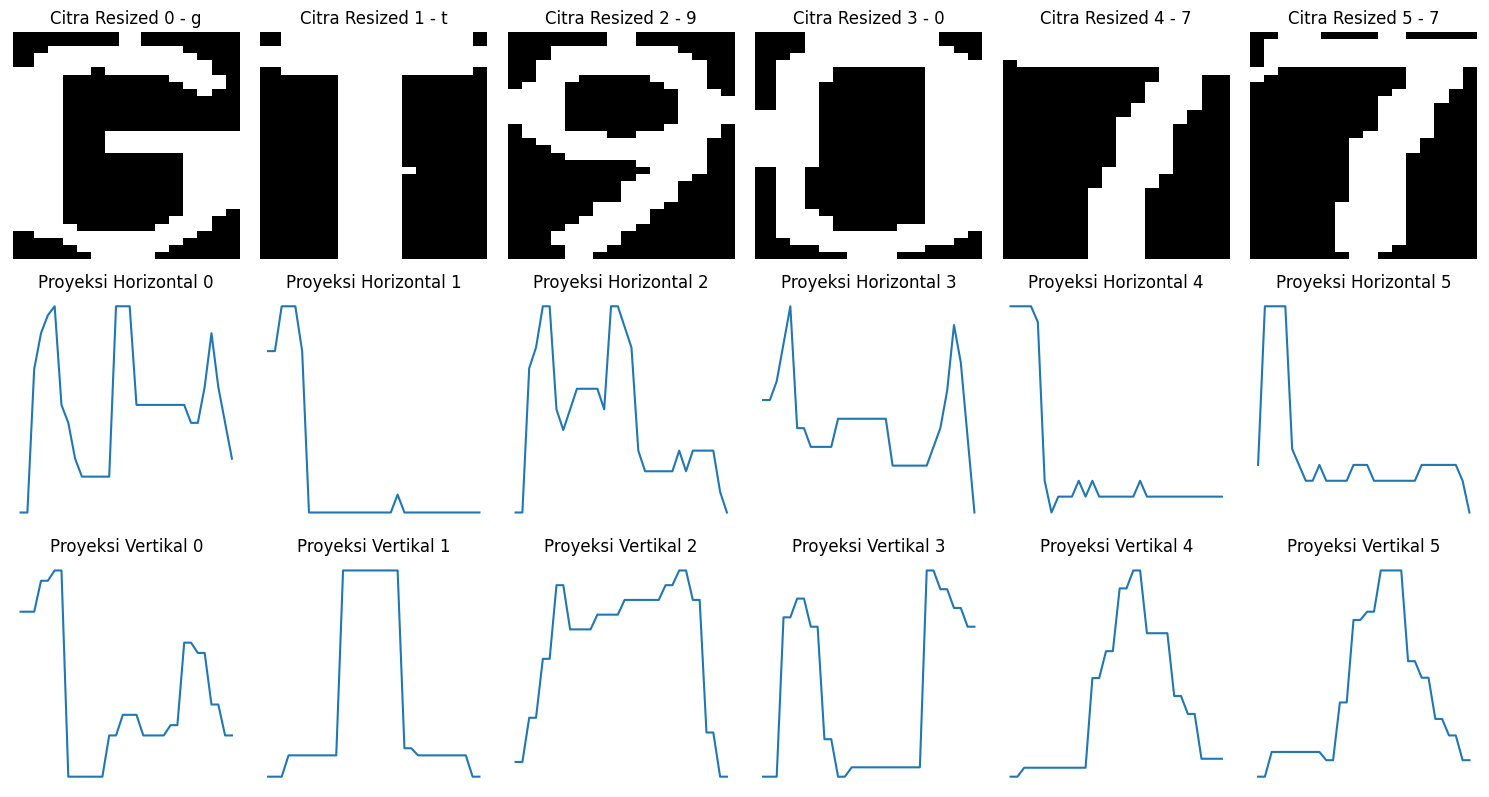

In [22]:
items = ['resized_img', 'horizontal_projection', 'vertical_projection', 'char']
temp_indexer = [f'{items[0]}_{x}' for x in range(6)]
temp_indexer = temp_indexer + [f'{items[1]}_{x}' for x in range(6)]
temp_indexer = temp_indexer + [f'{items[2]}_{x}' for x in range(6)]
temp_indexer = temp_indexer + [f'{items[3]}_{x}' for x in range(6)]
analysis_img = test_data.iloc[1][temp_indexer]

fig, axes = plt.subplots(3, 6, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < 6:
        ax.imshow(analysis_img[f'resized_img_{i}'], cmap='gray')
        ax.set_title(f'Citra Resized {i} - {analysis_img[f"char_{i}"]}')
    elif i < 12:
        ax.plot(analysis_img[f'horizontal_projection_{i-6}'])
        ax.set_title(f'Proyeksi Horizontal {i-6}')
    else:
        ax.plot(analysis_img[f'vertical_projection_{i-12}'])
        ax.set_title(f'Proyeksi Vertikal {i-12}')
    ax.axis('off')

plt.tight_layout()
plt.show()

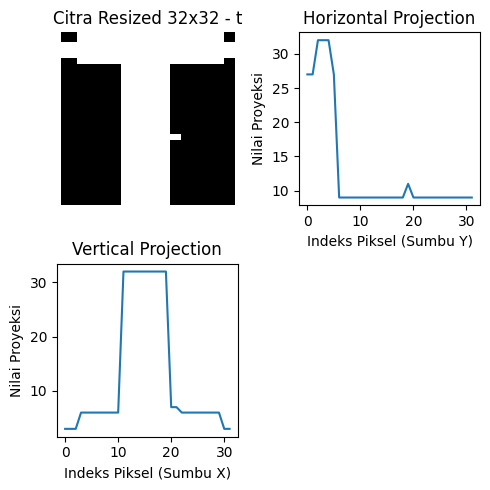

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.ravel()

axes[0].imshow(analysis_img[f'resized_img_1'], cmap='gray')
axes[0].set_title(f'Citra Resized 32x32 - {analysis_img["char_1"]}')
axes[0].axis('off')

axes[1].plot(analysis_img['horizontal_projection_1'])
axes[1].set_title('Horizontal Projection')
axes[1].set_xlabel('Indeks Piksel (Sumbu Y)')
axes[1].set_ylabel('Nilai Proyeksi')

axes[2].plot(analysis_img['vertical_projection_1'])
axes[2].set_title('Vertical Projection')
axes[2].set_xlabel('Indeks Piksel (Sumbu X)')
axes[2].set_ylabel('Nilai Proyeksi')
# axes[2].axis('off')

axes[3].axis('off')
plt.tight_layout()
plt.show()

# Analisis